# Assignment 3: Image Colourization [50 Pt]

In this assignment, you will build models to perform image colourization. That is, given a greyscale image, we wish to predict the colour at each pixel. Image colourization is a difficult problem for many reasons, one of which being that it is ill-posed: for a single greyscale image, there can be multiple, equally valid colourings.

To keep the training time manageable we will use the CIFAR-10 data set, which consists of images of size 32x32 pixels. For most of the questions we will use a subset of the dataset. The data loading script is included with the notebooks, and should download automatically the first time it is loaded.

We will be starting with a convolutional autoencoder and tweaking it along the way to improve our perforamnce. Then as a second part of the assignment we will compare the autoencoder approach to conditional generative adversarial networks (cGANs).

In the process, you are expected to learn to:

1. Clean and process the dataset and create greyscale images.
2. Implement and modify an autoencoder architecture.
3. Tune the hyperparameters of an autoencoder.
4. Implement skip connections and other techniques to improve performance.
5. Implement a cGAN and compare with an autoencoder.
6. Improve on the cGAN by trying one of several techniques to enhance training.

*This assignment is based on an assignment developed by Prof. Lisa Zhang and Prof. Jimmy Ba.*

### What to submit

Submit an HTML file containing all your code, outputs, and write-up
from parts A and B. Please take extra effort to make your answers and submissions readable. Do not display unnecessary outputs, only the ones that are important for supporting your answers.

You can produce a HTML file directly from Google Colab. The Colab instructions are provided at the end of this document.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

In [29]:
# TO BE COMPLETED
https://colab.research.google.com/drive/1ddJkEg7iRj0hOZwy6BWQAivDuW5GDCdW?usp=sharing

# PART A - Autoencoder
In this part we will construct and compare different autoencoder models for the image colourization task.

#### Helper code

Provided are some helper functions for loading and preparing the data. Note that you will need to use the Colab GPU for this assignment.

In [1]:
"""
Colourization of CIFAR-10 Horses via classification.
"""
import argparse
import math
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
######################################################################
# Setup working directory
######################################################################
%mkdir -p /content/a3/
%cd /content/a3


/content/a3


In [3]:
######################################################################
# Helper functions for loading data
######################################################################
# adapted from
# https://github.com/fchollet/keras/blob/master/keras/datasets/cifar10.py

import os
import pickle
import sys
import tarfile

import numpy as np
from PIL import Image
from six.moves.urllib.request import urlretrieve


def get_file(fname, origin, untar=False, extract=False, archive_format="auto", cache_dir="data"):
    datadir = os.path.join(cache_dir)
    if not os.path.exists(datadir):
        os.makedirs(datadir)

    if untar:
        untar_fpath = os.path.join(datadir, fname)
        fpath = untar_fpath + ".tar.gz"
    else:
        fpath = os.path.join(datadir, fname)

    print("File path: %s" % fpath)
    if not os.path.exists(fpath):
        print("Downloading data from", origin)

        error_msg = "URL fetch failure on {}: {} -- {}"
        try:
            try:
                urlretrieve(origin, fpath)
            except URLError as e:
                raise Exception(error_msg.format(origin, e.errno, e.reason))
            except HTTPError as e:
                raise Exception(error_msg.format(origin, e.code, e.msg))
        except (Exception, KeyboardInterrupt) as e:
            if os.path.exists(fpath):
                os.remove(fpath)
            raise

    if untar:
        if not os.path.exists(untar_fpath):
            print("Extracting file.")
            with tarfile.open(fpath) as archive:
                archive.extractall(datadir)
        return untar_fpath

    if extract:
        _extract_archive(fpath, datadir, archive_format)

    return fpath


def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    f = open(fpath, "rb")
    if sys.version_info < (3,):
        d = pickle.load(f)
    else:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    f.close()
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_cifar10(transpose=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = "cifar-10-batches-py"
    origin = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    path = get_file(dirname, origin=origin, untar=True)

    num_train_samples = 50000

    x_train = np.zeros((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.zeros((num_train_samples,), dtype="uint8")

    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        data, labels = load_batch(fpath)
        x_train[(i - 1) * 10000 : i * 10000, :, :, :] = data
        y_train[(i - 1) * 10000 : i * 10000] = labels

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if transpose:
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
    return (x_train, y_train), (x_test, y_test)

In [4]:
# Download CIFAR dataset
m = load_cifar10()

File path: data/cifar-10-batches-py.tar.gz
Extracting file.


## Part 1 Data Preparation [4 pt]

To start off run the above code to load the CIFAR dataset and then work through the following questions/tasks.

### Part (i) [2pt EXPLORATORY]
Verify that the dataset has loaded correctly. How many samples do we have? How is the data organized?

In [5]:
# TO BE COMPLETED

print(f'x_train shape: {m[0][0].shape}')
print(f'y_train shape: {m[0][1].shape}')
print(f'x_test shape: {m[1][0].shape}')
print(f'y_test shape: {m[1][1].shape}')

x_train shape: (50000, 3, 32, 32)
y_train shape: (50000, 1)
x_test shape: (10000, 3, 32, 32)
y_test shape: (10000, 1)


In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

x_train shape: (50000, 3, 32, 32) ->50000 N, 3 inputs, 32x32 pixel images
y_train shape: (50000, 1) ->50000 labels
x_test shape: (10000, 3, 32, 32)->10000 N, 3 inputs, 32x32 pixel images
y_test shape: (10000, 1) ->10000 labels

'''

'\nPROVIDE YOUR ANSWER BELOW\n\nx_train shape: (50000, 3, 32, 32) ->50000 N, 3 inputs, 32x32 pixel images\ny_train shape: (50000, 1) ->50000 labels\nx_test shape: (10000, 3, 32, 32)->10000 N, 3 inputs, 32x32 pixel images\ny_test shape: (10000, 1) ->10000 labels\n\n'

### Part (ii) [2pt EXPLORATORY]

Provided below is sample code to preproces the data to select only images of horses, which will help to simplify the goals of the assignment. The function also converts the colour images to greyscale to create our input data.

In [6]:
# select a single category.
HORSE_CATEGORY = 7

# convert colour images into greyscale
def process(xs, ys, max_pixel=256.0, downsize_input=False):
    """
    Pre-process CIFAR10 images by taking only the horse category,
    shuffling, and have colour values be bound between 0 and 1

    Args:
      xs: the colour RGB pixel values
      ys: the category labels
      max_pixel: maximum pixel value in the original data
    Returns:
      xs: value normalized and shuffled colour images
      grey: greyscale images, also normalized so values are between 0 and 1
    """
    xs = xs / max_pixel
    xs = xs[np.where(ys == HORSE_CATEGORY)[0], :, :, :]
    npr.shuffle(xs)

    grey = np.mean(xs, axis=1, keepdims=True)

    if downsize_input:
        downsize_module = nn.Sequential(
            nn.AvgPool2d(2),
            nn.AvgPool2d(2),
            nn.Upsample(scale_factor=2),
            nn.Upsample(scale_factor=2),
        )
        xs_downsized = downsize_module.forward(torch.from_numpy(xs).float())
        xs_downsized = xs_downsized.data.numpy()
        return (xs, xs_downsized)
    else:
        return (xs, grey)


The provided get_batch function creates a dataloader (or function) to batch the samples.

In [7]:
# dataloader for batching samples

def get_batch(x, y, batch_size):
    """
    Generated that yields batches of data

    Args:
      x: input values
      y: output values
      batch_size: size of each batch
    Yields:
      batch_x: a batch of inputs of size at most batch_size
      batch_y: a batch of outputs of size at most batch_size
    """
    N = np.shape(x)[0]
    assert N == np.shape(y)[0]
    for i in range(0, N, batch_size):
        batch_x = x[i : i + batch_size, :, :, :]
        batch_y = y[i : i + batch_size, :, :, :]
        yield (batch_x, batch_y)


Run the above helper code and call the appropriate fucntion to verify and visualize that we are able to generate different batches of data with the correct class of images (i.e., horses).

Write code to visualize 5 train and test/val images.

In [8]:
# code to load different batches of horse dataset

print("Loading data...")
(x_train, y_train), (x_test, y_test) = load_cifar10()

print("Transforming data...")
train_rgb, train_grey = process(x_train, y_train)
test_rgb, test_grey = process(x_test, y_test)


Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...


In [9]:
# shape of data and labels before selection
print(x_train.shape, y_train.shape)

(50000, 3, 32, 32) (50000, 1)


In [10]:
# shape of training data
print('Training Data: ', train_rgb.shape, train_grey.shape)
# shape of testing data
print('Testing Data: ', test_rgb.shape, test_grey.shape)

Training Data:  (5000, 3, 32, 32) (5000, 1, 32, 32)
Testing Data:  (1000, 3, 32, 32) (1000, 1, 32, 32)


Load Batches

In [11]:
# TO BE COMPLETED

train_load_batch = get_batch(train_grey, train_rgb, 5)
test_load_batch = get_batch(test_grey, test_rgb, 5)

Write code to visualize 5 train/test images

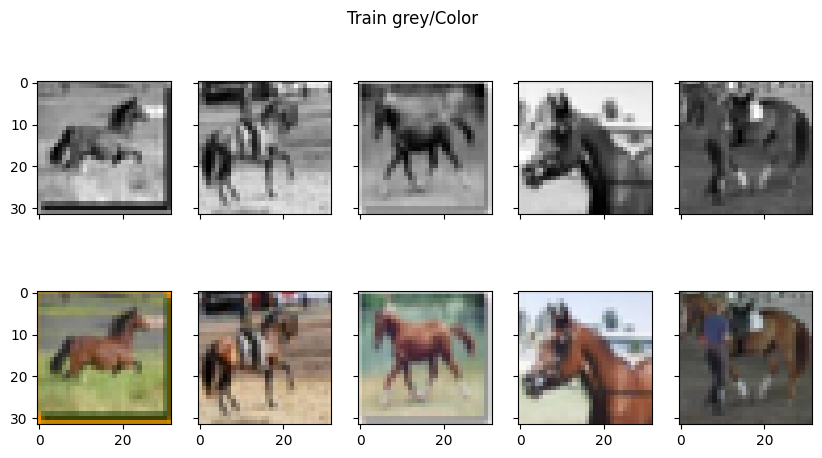

In [ ]:
# TO BE COMPLETED

dataiter = iter(train_load_batch)
images, labels = next (dataiter)
fig = plt.figure(figsize=(10, 5))

for idx in np.arange(5):
    ax = fig.add_subplot(2, 5, idx+1)
    plt.imshow(np.transpose(images[idx], (1, 2, 0)), cmap='gray')
for idx in np.arange(5):
    ax = fig.add_subplot(2, 5, idx+6)
    plt.imshow(np.transpose(labels[idx], (1, 2, 0)), cmap='gray')
fig.suptitle('Train grey/Color')
for ax in fig.get_axes():
    ax.label_outer()

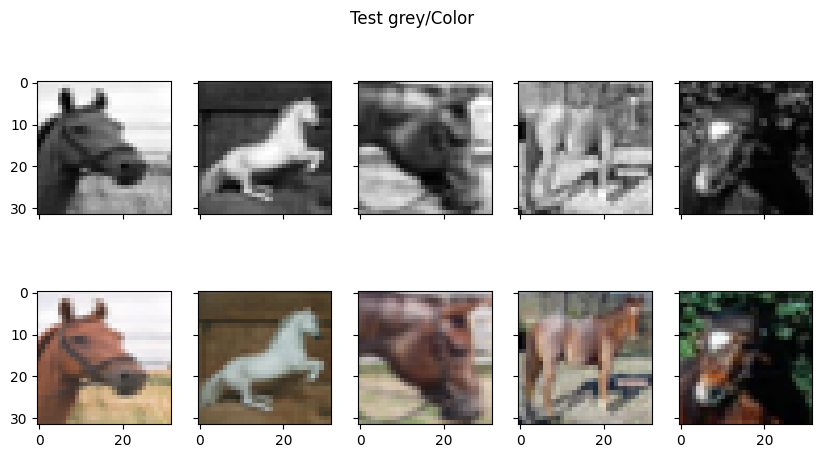

In [ ]:
#Test data
dataiter = iter(test_load_batch)
images, labels = next (dataiter)
fig = plt.figure(figsize=(10, 5))

for idx in np.arange(5):
    ax = fig.add_subplot(2, 5, idx+1)
    plt.imshow(np.transpose(images[idx], (1, 2, 0)), cmap='gray')
for idx in np.arange(5):
    ax = fig.add_subplot(2, 5, idx+6)
    plt.imshow(np.transpose(labels[idx], (1, 2, 0)), cmap='gray')
fig.suptitle('Test grey/Color')
for ax in fig.get_axes():
    ax.label_outer()

## Part 2 Image Colourization as Regression [4 pt]

There are many ways to frame the problem of image colourization as a machine learning problem. One naive approach is to frame it as a regression problem, where we build a model to predict the RGB intensities at each pixel given the greyscale input. In this case, the outputs are continuous, and so squared error can be used to train the model.

In this section, you will be the training neural networks using cloud GPUs. Run the helper code and answer the questions that follow.

#### Helper Code

Regression Architecture

In [ ]:
class RegressionCNN(nn.Module):
    def __init__(self, kernel, num_filters):
        # first call parent's initialization function
        super().__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(3, 3, kernel_size=kernel, padding=padding)

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.finalconv(out)
        return out

Training code

In [12]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): rgb as labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, gen=None):

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # LOAD THE MODEL
    if gen is None:
        Net = globals()[args.model]
        gen = Net(args.kernel, args.num_filters)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(gen.parameters(), lr=args.learn_rate)

    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        gen.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        gen.train()  # Change model to 'train' mode
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = gen(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        print(epoch, loss.cpu().detach())
        if args.plot:
          visual(images, labels, outputs, args.gpu, 1)

    return gen

Training visualization code

In [13]:
# visualize 5 train/test images
def visual(img_grey, img_real, img_fake, gpu = 0, flag_torch = 0):

  if gpu:
    img_grey = img_grey.cpu().detach()
    img_real = img_real.cpu().detach()
    img_fake = img_fake.cpu().detach()

  if flag_torch:
    img_grey = img_grey.numpy()
    img_real = img_real.numpy()
    img_fake = img_fake.numpy()

  if flag_torch == 2:
    img_real = np.transpose(img_real[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()
    img_fake = np.transpose(img_fake[:, :, :, :, :], [0, 4, 2, 3, 1]).squeeze()

  #correct image structure
  img_grey = np.transpose(img_grey[:5, :, :, :], [0, 2, 3, 1]).squeeze()
  img_real = np.transpose(img_real[:5, :, :, :], [0, 2, 3, 1])
  img_fake = np.transpose(img_fake[:5, :, :, :], [0, 2, 3, 1])

  for i in range(5):
      ax = plt.subplot(3, 5, i + 1)
      ax.imshow(img_grey[i], cmap='gray')
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 5)
      ax.imshow(img_real[i])
      ax.axis("off")
      ax = plt.subplot(3, 5, i + 1 + 10)
      ax.imshow(img_fake[i])
      ax.axis("off")
  plt.show()

Main training loop for regression CNN

In [ ]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}

args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

### Part (i) [2pt EXPLORATORY]
Describe the model RegressionCNN. How many convolution layers does it have? What are the filter sizes and number of filters at each layer?

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW


It is a simple regression convolution neural network that takes 1 input
and in the end produce 3 output (greyscale images input and output RGB images)
It requires 2 parameters: the size of the kernels and the number of filters.

It uses a convolutional neural network (CNN) architecture with
both down-sampling (encoder) and up-sampling (decoder) components.

It has 6 convolution layes with the following number of filters:
downconv1: num_filters filters.
downconv2: 2*num_filters filters.
rfconv: 2*num_filters filters.
upconv1: num_filters filters.
upconv2: 3 output channels (assuming RGB images).
Final Convolution: 3 output channels (for RGB images).

'''

### Part (ii) [2pt EXPLORATORY]
Run the regression training code (should run without errors). This will generate some images. How many epochs are we training the CNN model in the given setting?

In [ ]:
# TO BE COMPLETED






In [ ]:
'''
PROVIDE YOUR ANSWER BELOW


It did run without errors
It was trained with 25 epochs as defined in the arguments diccionary
Final training loss = 0.0091



'''

### Part (iii) [1pt RESULTS]
Re-train a couple of new models using a different number of training epochs. You may train each new models in a new code cell by copying and modifying the code from the last notebook cell. Comment on how the results (output images, training loss) change as we increase or decrease the number of epochs.

In [ ]:
# TO BE COMPLETED
# Decrease epochs to 15
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 100,
    "epochs": 15,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# TO BE COMPLETED
# Decrease epochs to 15
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "RegressionCNN",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 100,
    "epochs": 35,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

for 15 epochs the tranning loss increased to 0.0101
for 35 epochs the training loos decreased to 0.0078
for 25 (initial training epochs size) the trainining loss was 0.0091

The difference is not very significant even with large epochs sizes.
To obtain a better result it won't matter if we increase the epoch size

'''

### Part (iv) [1pt MODEL]

Modify the convolutional neural network to include additional convolutional layers. Specifically, add an additional convolutional layer with the same number of filters as the previous layer and the same kernel size. Ensure that the appropriate parameters are modified (e.g. input and output channels, padding) to accommodate this change.

In [ ]:
# TO BE COMPLETED

class ModifiedRegressionCNN(nn.Module):
    def __init__(self, kernel, num_filters):
        # first call parent's initialization function
        super().__init__()
        padding = kernel // 2

        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2),)
        #new layer
        self.downconv3 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),)

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),)
        self.finalconv = nn.Conv2d(3, 3, kernel_size=kernel, padding=padding)

    def forward(self, x):
        out = self.downconv1(x)
        out = self.downconv2(out)
        out = self.downconv3(out) #new layer
        out = self.rfconv(out)
        out = self.upconv1(out)
        out = self.upconv2(out)
        out = self.finalconv(out)
        return out

## Part 3 Skip Connections [8 pt]
A skip connection in a neural network is a connection which skips one or more layer and connects to a later layer. In this section we will be incorporating skip connections to improve on our model architecture.

### Part (i) [3pt MODEL]
Add a skip connection from the first layer to the last, second layer to the second last, etc.
That is, the final convolution should have both the output of the previous layer and the initial greyscale input as input. This type of skip-connection architecture and is called a "UNet". Following the CNN class that you have completed, complete the __init__ and forward methods of the UNet class.
Hint: You will need to use the function torch.cat to add skip connections.

In [ ]:
#complete the code

class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ###############
        ###################################################
        self.downconv1 = nn.Sequential(
            nn.Conv2d(1, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2))

        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())

        # Decoder (upward path)
        self.upconv1 = nn.Sequential(
            nn.Conv2d(num_filters*4, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.Upsample(scale_factor=2))
        self.upconv2 = nn.Sequential(
            nn.Conv2d(num_filters*2, 3, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Upsample(scale_factor=2))
        self.finalconv = nn.Conv2d(3, 3, kernel_size=kernel, padding=padding)



    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        e1 = self.downconv1(x)
        e2 = self.downconv2(e1)

        rf_out = self.rfconv(e2)

        # Decoder with skip connections
        cat1 = torch.cat([rf_out, e2], dim=1)
        d1 = self.upconv1(cat1)

        cat0 = torch.cat([d1, e1], dim=1)
        d2 = self.upconv2(cat0)

        # Final output
        out = self.finalconv(d2)
        return out

### Part (ii) [2pt RESULTS]
Train the "UNet" model for the same amount of epochs as the previous CNN and plot the training curve using a batch size of 100.

In [ ]:
# Main training loop for UNet
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 100,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

How does the result compare to the previous model? Did skip connections improve the validation loss? Did the skip connections improve the output qualitatively? How? Give at least two reasons why skip connections might improve the performance of our CNN models.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW


It it noticeable an improvement in the resolution of the image. It seems that
the output has the same resolution than the original images.
The training loss has also a decrease of 0.006 at the 25 epoch
Skip connections allows gradient to flow more easily during backpropagation since
the gradient tends to be reduced when there are multiple layers. Preventing
gradient vanishing gives a more stable and efficient traning
Also, skip connection allows to maintain features throughout different layers since
we are concatenating first layers to final layers.



'''

### Part (iii) [2pt RESULTS]
Re-train a few more "UNet" models using different mini batch sizes with a fixed number of epochs.

In [ ]:
# TO BE COMPLETED
# batch size: 250 and epochs 25
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 250,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)






Output hidden; open in https://colab.research.google.com to view.

*Describe* the effect of batch sizes on the training/validation loss, and the final image output.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW
With a bigger batch size of 250 it was obtained a training loss of 0.0084
Larger batch sizes guarantee convergence to the global optimum
but may lead to suboptimal generalization.


'''

In [ ]:
# TO BE COMPLETED
# batch size: 50 and epochs 25
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "UNet",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 50,
    "epochs": 25,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
"""
  It was obtained a better training loss with a batch size of 50.
  It may be because smaller batch size provide a better generalizatio
  in images.
"""

# PART B - Conditional GAN

In this second half of the assignment we will construct a conditional generative adversarial network for our image colourization task. This second half of the assignment should be started after the lecture on generative adversarial networks (GANs).

## Part 1 Conditional GAN [10 Pt]

To start we will be modifying the previous sample code to construct and train a conditional GAN. Later you will have the opportunity to explore other modifications that can be made to our architecture to achieve the best results on image colourization model.


### Part (i) [2pt MODEL]
Modify the provided training code to implement a generator. Then test to verify it works on the desired input

Hint: you can reuse your earlier autoencoder models here to act as a generator, if you do so, the architecture will be more like the pix2pix architecture (see https://phillipi.github.io/pix2pix/ for more details).

In [ ]:
class Generator_old(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ###############
        ###################################################
        self.downconv1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU(),
            nn.MaxPool2d(2))
        """self.downconv2 = nn.Sequential(
            nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.rfconv = nn.Sequential(
            nn.Conv2d(num_filters*2, num_filters*2, kernel_size=kernel, padding=padding),
            nn.BatchNorm2d(num_filters*2),
            nn.ReLU())"""
        #decoder
        self.upconv1 = nn.Sequential(
            nn.ConvTranspose2d(num_filters, num_colours, kernel_size=kernel, padding=padding, stride=stride, output_padding=output_padding),
            nn.Tanh())
            #nn.BatchNorm2d(num_filters),
            #nn.ReLU(),)
            #nn.Upsample(scale_factor=2))
        """self.upconv2 = nn.Sequential(
            nn.ConvTranspose2d(num_filters*2, num_colours, kernel_size=kernel, padding=padding, stride=stride, output_padding=output_padding),
            nn.BatchNorm2d(num_colours),
            nn.ReLU(),)
            #nn.Upsample(scale_factor=2))
        """
        # Final output
        self.finalconv = nn.Conv2d(num_colours, num_colours, kernel_size=kernel, padding=padding)

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        ###################################################
        e1 = self.downconv1(x)
        #e2 = self.downconv2(e1)
        #e3 = self.rfconv(e2)
        # Decoder with skip connections
        #cat1 = torch.cat([e3, e2], dim=1)
        d1 = self.upconv1(e1)
        #cat2 = torch.cat([d1, e1], dim=1)
        #d2 = self.upconv2(cat2)
        # Final output
        out = self.finalconv(d1)
        return out

In [15]:
class Generator2(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super(Generator2, self).__init__()
        # Define the encoder blocks
        self.enc1 = self.encoder_block(1, 64, kernel_size=4, stride=2, padding=1, batch_norm=False) # Input: 1 x 32 x 32, Output: 64 x 16 x 16
        self.enc2 = self.encoder_block(64, 128, kernel_size=4, stride=2, padding=1, batch_norm=True) # Input: 64 x 16 x 16, Output: 128 x 8 x 8
        self.enc3 = self.encoder_block(128, 256, kernel_size=4, stride=2, padding=1, batch_norm=True) # Input: 128 x 8 x 8, Output: 256 x 4 x 4
        self.enc4 = self.encoder_block(256, 512, kernel_size=4, stride=2, padding=1, batch_norm=True) # Input: 256 x 4 x 4, Output: 512 x 2 x 2
        self.enc5 = self.encoder_block(512, 512, kernel_size=4, stride=2, padding=1, batch_norm=True) # Input: 512 x 2 x 2, Output: 512 x 1 x 1
        # Define the decoder blocks
        self.dec1 = self.decoder_block(512, 512, kernel_size=4, stride=2, padding=1, dropout=True) # Input: 512 x 1 x 1, Output: 512 x 2 x 2
        self.dec2 = self.decoder_block(1024, 256, kernel_size=4, stride=2, padding=1, dropout=True) # Input: 1024 x 2 x 2, Output: 256 x 4 x 4
        self.dec3 = self.decoder_block(512, 128, kernel_size=4, stride=2, padding=1, dropout=False) # Input: 512 x 4 x 4, Output: 128 x 8 x 8
        self.dec4 = self.decoder_block(256, 64, kernel_size=4, stride=2, padding=1, dropout=False) # Input: 256 x 8 x 8, Output: 64 x 16 x 16
        self.dec5 = self.decoder_block(128, 3, kernel_size=4, stride=2, padding=1, dropout=False, batch_norm=False) # Input: 128 x 16 x 16, Output: 3 x 32 x 32
        # Define the final activation
        self.tanh = nn.Tanh()

    def encoder_block(self, in_channels, out_channels, kernel_size, stride, padding, batch_norm):
        # Define the encoder block
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def decoder_block(self, in_channels, out_channels, kernel_size, stride, padding, dropout, batch_norm=True):
        # Define the decoder block
        layers = []
        layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        if dropout:
            layers.append(nn.Dropout(0.5))
        layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass of the generator
        # Encode the input
        e1 = self.enc1(x) # 64 x 16 x 16
        e2 = self.enc2(e1) # 128 x 8 x 8
        e3 = self.enc3(e2) # 256 x 4 x 4
        e4 = self.enc4(e3) # 512 x 2 x 2
        e5 = self.enc5(e4) # 512 x 1 x 1
        # Decode the output
        d1 = self.dec1(e5) # 512 x 2 x 2
        d2 = self.dec2(torch.cat([d1, e4], 1)) # 256 x 4 x 4
        d3 = self.dec3(torch.cat([d2, e3], 1)) # 128 x 8 x 8
        d4 = self.dec4(torch.cat([d3, e2], 1)) # 64 x 16 x 16
        d5 = self.dec5(torch.cat([d4, e1], 1)) # 3 x 32 x 32
        # Apply the final activation
        out = self.tanh(d5) # 3 x 32 x 32
        return out

Write code to test the generator is working as intended.

Loading data...
File path: data/cifar-10-batches-py.tar.gz
Transforming data...
Beginning training ...
0 tensor(0.0062)


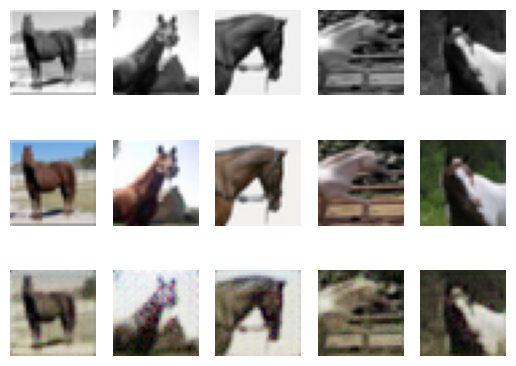

In [16]:
# TO BE COMPLETED

# epochs 1
cnn = None
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator2",
    "kernel": 4,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 50,
    "epochs": 1,
    "seed": 0,
    "plot": True,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)


### Part (ii) [2pt MODEL]
Modify the provided training code to implement a discriminator. Then test to verify it works on the desired input.

Hint: You should build a simple CNN model to act as a discriminator for real and fake images.

In [15]:
# discriminator code

class Discriminator_old(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ###############
        ###################################################
        self.conv1 = nn.Conv2d(num_colours + num_in_channels, num_filters, kernel_size=kernel, padding=padding, stride=stride)
        #self.relu1 = nn.ReLU()
        self.relu1 = nn.LeakyReLU(0.2)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(num_filters, num_filters*2, kernel_size=kernel, padding=padding, stride=stride)
        #self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(num_filters*2)
        self.relu2 = nn.LeakyReLU(0.2)
        self.maxpool2 = nn.MaxPool2d(2)
        #final layer
        self.fc = nn.Sequential(
            nn.Linear(num_filters*2 * 2 * 2, 1), # Output 1 for real, 0 for fake
            )

    def forward(self, x, img_greyscale):

        ############### YOUR CODE GOES HERE ###############
        ###################################################
        x = torch.cat([x, img_greyscale], dim=1)
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.bn2(self.conv2(x))))
        #x = self.relu1(self.conv1(x))
        #x = self.relu2(self.bn2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the features
        out = self.fc(x)

        return out

In [17]:
class Discriminator(nn.Module):
    def __init__(self, kernel, num_filters, num_colours=3, num_in_channels=1):
        super(Discriminator, self).__init__()
        # Define the discriminator blocks
        self.block1 = self.discriminator_block(4, 64, kernel_size=4, stride=2, padding=1, batch_norm=False) # Input: 4 x 32 x 32, Output: 64 x 16 x 16
        self.block2 = self.discriminator_block(64, 128, kernel_size=4, stride=2, padding=1, batch_norm=True) # Input: 64 x 16 x 16, Output: 128 x 8 x 8
        self.block3 = self.discriminator_block(128, 256, kernel_size=4, stride=2, padding=1, batch_norm=True) # Input: 128 x 8 x 8, Output: 256 x 4 x 4
        self.block4 = self.discriminator_block(256, 512, kernel_size=4, stride=1, padding=1, batch_norm=True) # Input: 256 x 4 x 4, Output: 512 x 3 x 3
        self.block5 = self.discriminator_block(512, 1, kernel_size=4, stride=1, padding=1, batch_norm=False) # Input: 512 x 4 x 4, Output: 1 x 2 x 2
        # Define the final activation
        self.sigmoid = nn.Sigmoid()

    def discriminator_block(self, in_channels, out_channels, kernel_size, stride, padding, batch_norm):
        # Define the discriminator block
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def forward(self, x, y):
        # Forward pass of the discriminator
        # Concatenate the input and the target
        z = torch.cat([x, y], 1) # 4 x 32 x 32
        # Apply the discriminator blocks
        z = self.block1(z) # 64 x 16 x 16
        z = self.block2(z) # 128 x 8 x 8
        z = self.block3(z) # 256 x 4 x 4
        z = self.block4(z) # 512 x 4 x 4
        #print(z.shape)
        z = self.block5(z) # 1 x 3 x 3
        #print(z.shape)
        # Apply the final activation
        out = self.sigmoid(z) # 1 x 2 x 2
        #print(out.shape)
        return out

Write code to test that the discriminator is working as intended.

In [19]:
discriminator = Discriminator(kernel=3, num_filters=32, num_colours=3, num_in_channels=1)

In [20]:
# TO BE COMPLETED

fake_image = torch.randn(1, 3, 32, 32)
y = torch.randn(1, 1, 32, 32) #grey image
decision = discriminator(fake_image, y)
print("Discriminator decision:", decision)  # Positive values for real,
decision.shape

Discriminator decision: tensor([[[[0.4912, 0.5781],
          [0.4994, 0.4940]]]], grad_fn=<SigmoidBackward0>)


torch.Size([1, 1, 2, 2])

In [ ]:
"""
  It is a negative value so the image is fake
"""

### Part (iii) [2pt MODEL]
Modify the provided training code to implement the training needed for a conditional GAN.

In [21]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): rgb as labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)
    lambda_L1 = 100
    beta1 = 0.5

    # Save directory
    save_dir = "outputs/" + args.experiment_name
    num_in_channels = 1
    # LOAD THE MODEL
    if cnn is None:
        Gen = globals()[args.model]
        cnn = Gen(args.kernel, args.num_filters)
        discriminator = Discriminator(args.kernel, args.num_filters)
    # LOSS FUNCTION
    gan_criterion = nn.BCELoss() # Binary cross entropy loss for the GAN loss
    l1_criterion = nn.L1Loss() # L1 loss for the pixel-wise loss
    #criterion = nn.BCELoss()

    g_optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate, betas=(beta1, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=args.learn_rate, betas=(beta1, 0.999))
    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()  # Change model to 'train' mode
        discriminator.train()
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            #--->ADDED 5
            img_grey = images # 1 x 32 x 32
            img_real = labels # 3 x 32 x 32
            batch_size = img_real.size(0)


            # Create the labels
            real_labels = torch.ones(batch_size, 1, 2, 2).cuda() # 1 x 2 x 2
            fake_labels = torch.zeros(batch_size, 1, 2, 2).cuda() # 1 x 2 x 2
            # Train the discriminator
            # Zero the gradients of the discriminator
            d_optimizer.zero_grad()
            # Generate fake images using the generator
            fake_images = cnn(img_grey) # 3 x 32 x 32
            # Compute the discriminator outputs for the real and fake images
            d_real = discriminator(img_grey, img_real) # 1 x 2 x 2
            d_fake = discriminator(img_grey, fake_images.detach()) # 1 x 2 x 2
            #print(f"shape d_fake: {d_fake.shape}")
            #print(f"real_labels: {real_labels.shape}")
            # Compute the discriminator losses
            d_real_loss = gan_criterion(d_real, real_labels)
            d_fake_loss = gan_criterion(d_fake, fake_labels)
            d_loss = d_real_loss + d_fake_loss
            # Backpropagate the discriminator losses
            d_loss.backward()
            # Update the discriminator parameters
            d_optimizer.step()
            # Train the generator
            # Zero the gradients of the generator
            g_optimizer.zero_grad()
            # Generate fake images using the generator
            fake_images = cnn(img_grey) # 3 x 32 x 32
            # Compute the discriminator output for the fake images
            d_fake = discriminator(img_grey, fake_images) # 1 x 2 x 2
            # Compute the generator losses
            g_gan_loss = gan_criterion(d_fake, real_labels)
            g_l1_loss = l1_criterion(fake_images, img_real) * lambda_L1
            g_loss = g_gan_loss + g_l1_loss
            # Backpropagate the generator losses
            g_loss.backward()
            # Update the generator parameters
            g_optimizer.step()
            # Print the losses
            if i % 50 == 0:
                print(f"Epoch {epoch}, Batch {i}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

            losses.append((g_loss.cpu().detach().numpy(), d_loss.cpu().detach().numpy()))

        print(epoch, g_loss.cpu().detach(), d_loss.cpu().detach())
        visual(images, labels, fake_images, args.gpu, 1)
    torch.save(cnn, "generator.pth")
    torch.save(discriminator, "discriminator.pth")

    return cnn

### Part (iv) [2pt RESULTS]
Train a conditional GAN for image colourization and comment on how the results compare to the autoencoder architectures from part 1.

In [22]:
cnn = None
discriminator = None

In [23]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator2",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 50,
    "epochs": 75,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

#batch size of 50 with 100 epochs seamed to work

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

Numerous methods were attempted to improve the results for this task.
Using a simple CNN as the discriminator (model: Discriminator_old) yielded
poor results. The training loss of the discriminator remained consistently low,
indicating that it was not learning. As a result, the generator (model: Generator_old) failed to learn as well.
Therefre, an architecture with multiple layers was implemented based on:
https://github.com/Macbull/room_layout/blob/24c2ca1affdd77ca5cf7fb94bc25af525ad5b5ad/OneGan-0.3.2/onegan/models.py

Model used: Generator2 and Discriminator
Then it was observed that the loss in the discriminator and the
generator were becoming similar, indicating that the generator was
learning to produce better images to deceive the discriminator
if we compare the The Pix2Pix architecture(UNet Generator) to the autoencoder architectures from part 1
The results improved drastrically.The Pix2Pix has better results preserving details.
The final results with just 50 epoch were almost identical than the original.


'''

### Part (v) [2pt DISCUSSION]

There are two ways to implement the conditional GAN. The first is a standard conditional GAN for which the generator is a decoder with an input that is random noise with a conditional. The second is the pix2pix architecture where the generator is a UNet architecture with a greyscale image input.

Briefly describe the pros and cons of the two different approaches in regards to the image colourization task.

Limit your answer to no more than 100 words.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW
The standard Conditional GAN (Generator as Decoder) seen in Pre3B was:
  - Simplicity and had a flexibility in handling various conditionals.
  - tends to struggle with fine details, lacks spatial coherence
  - tends to struggle to generate realistic details in colorization
In the other hand Pix2Pix (UNet Generator) was:
  - It is strong spatial coherence and better at preserving details.
  However, it was too complexity, requires paired data for training.
  It also tends to produce unrealistic colors or artifacts in some cases.
'''

## Part 2 New Data [5 Pt]

### Part (i) [3pt RESULTS]

Retrieve sample pictures from online and demonstrate how well your best model performs. Provide all your code, including any image processing that you need to perform, and provide outputs on all the greyscale images you tested. Your outputs should show the greyscale images, ground truth, and model generated image.

torch.Size([1, 1, 32, 32])


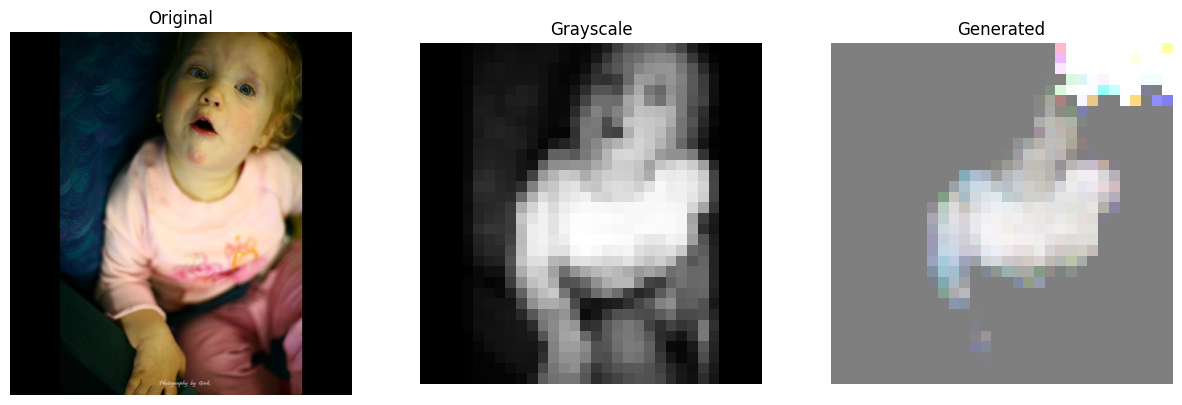

torch.Size([1, 1, 32, 32])


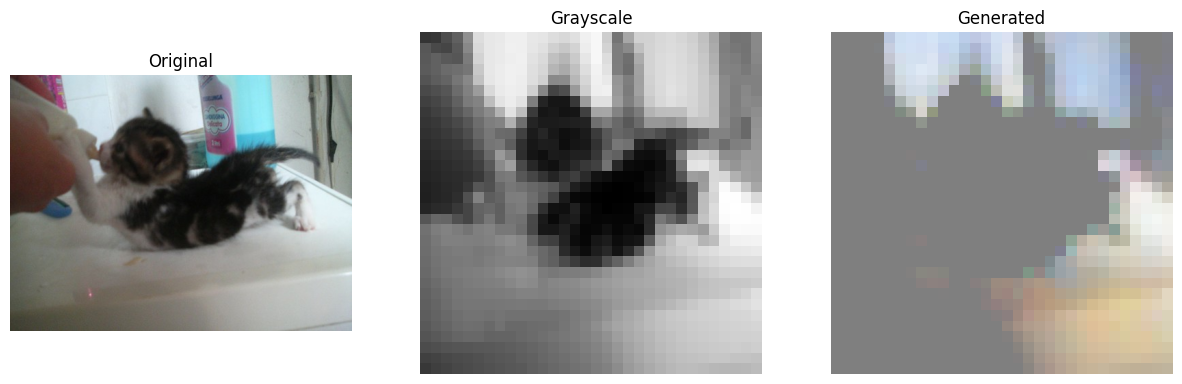

torch.Size([1, 1, 32, 32])


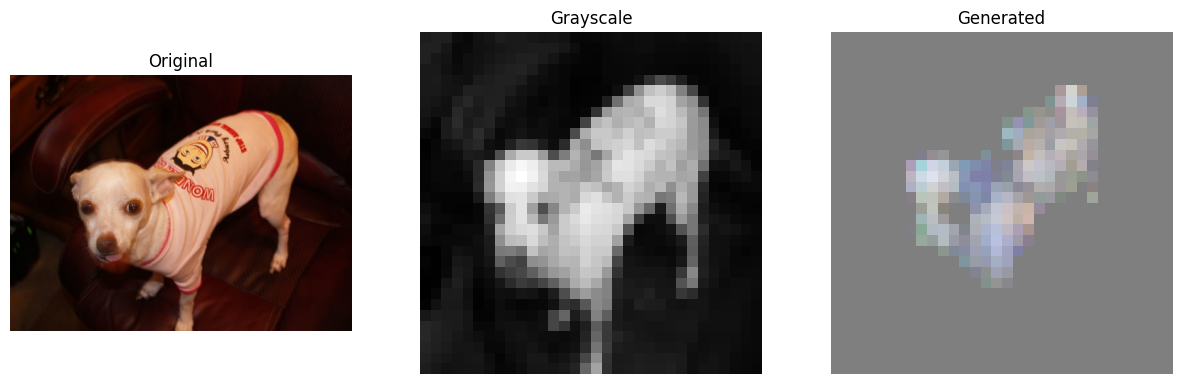

torch.Size([1, 1, 32, 32])


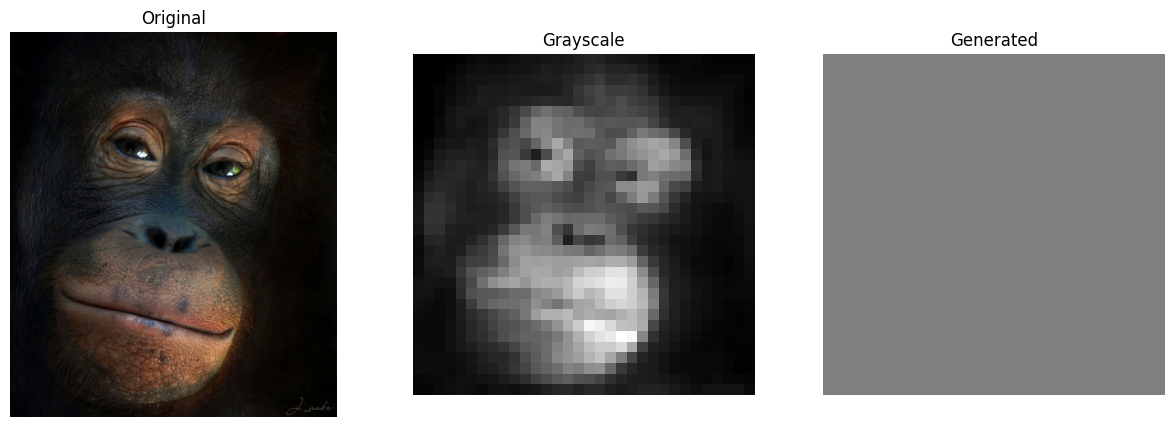

torch.Size([1, 1, 32, 32])


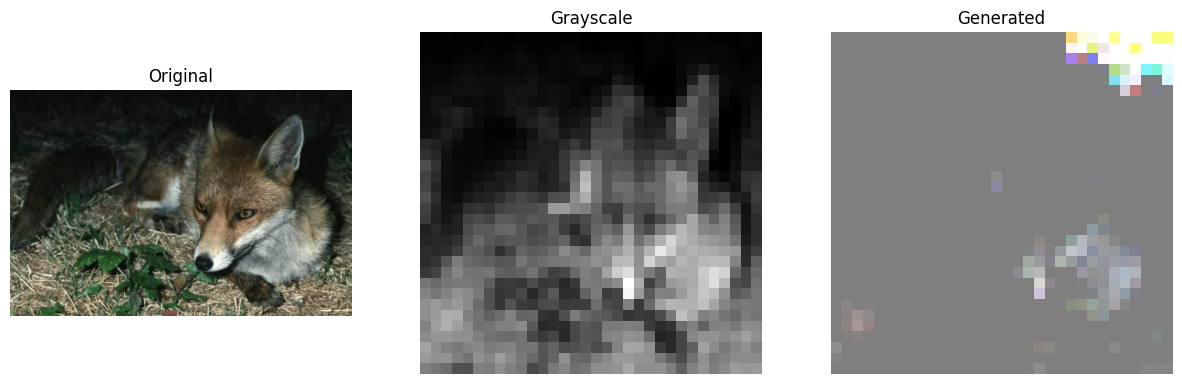

In [24]:
# TO BE COMPLETED
# Import the necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import requests
from PIL import Image
from io import BytesIO

# Load the generator model
G = torch.load("generator.pth") # Load the generator model from a file
G.eval() # Set the generator model to evaluation mode

# Define the image transformations
transform = transforms.Compose([
    transforms.Grayscale(), # Convert the images to grayscale
    transforms.Resize((32, 32)), # Resize the images to 32x32 pixels
    transforms.ToTensor(), # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5,)) # Normalize the images
])

# Define the inverse transformation
inverse_transform = transforms.Compose([
    transforms.Normalize((-1,), (2,)), # Undo the normalization
    transforms.ToPILImage() # Convert the tensors to PIL images
])

# Define a function to display the images
def display_images(images, titles):
    # Display a list of images with titles
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(title)
        axes[i].axis("off")
    plt.show()

# Define a list of sample ImageNet URLs from
# https://planspace.org/20170430-sampling_imagenet/
imagenet_urls = [
    "https://farm4.static.flickr.com/3175/2737866473_7958dc8760.jpg", #baby
    #"https://github.com/ajschumacher/imagen/blob/master/imagen/n00007846_152343_person.jpg", #man
    "https://farm4.static.flickr.com/3276/2875184020_9944005d0d.jpg", # gato
    "http://farm3.static.flickr.com/2199/1659368303_4dbf9b312a.jpg", # perro
    "https://farm3.static.flickr.com/2531/4094333885_e8462a8338.jpg", # mono
    "https://planspace.org/20170430-sampling_imagenet/img/n02118333_27_fox.jpg", #zorro
]

# Loop through the ImageNet URLs
for url in imagenet_urls:
    # Download the image
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    # Convert the image to grayscale and resize it
    gray_image = transform(image).cuda()
    # Generate a color image from the grayscale image
    gray_image_input = gray_image.unsqueeze(0)
    print(gray_image_input.shape)
    color_image = G(gray_image_input).squeeze(0)
    # Apply the inverse transformation to the images
    gray_image = inverse_transform(gray_image)
    color_image = inverse_transform(color_image)
    # Display the images
    display_images([image, gray_image, color_image], ["Original", "Grayscale", "Generated"])


### Part (ii) [2pt DISCUSSION]

Summarize the qualitative performance of your best model on image colourization of new data and provide some reasons why it performs the way it does. Are there certain types of images on which your model works better than on others? Explain.



In [ ]:
'''
PROVIDE YOUR ANSWER BELOW
My best model performs reasonably well on images with few features,
but it doesn't perform as well on others.
Resolution can be a contributing factor, but it appears that my best model has
difficulty handling complex textures, shadows, and backgrounds.
Additionally, it tends to overexpose some images with dark backgrounds,
indicating potential overfitting during training.
This may be a result of insufficient diversity in our dataset,
particularly with respect to various animal features that the model should be able to recognize.



'''

## Part 3 Exploration [6 Pt]

At this point we have trained a few different generative models for our image colourization task with varying results. What makes this work exciting is that there many other approaches we could take. In this part of the assignment you are asked to consider some modifications you could make to improve the results and provide some comments on why those approaches could be beneficial.

### Part (i) [2pt DISCUSSION]

We've seen several times in this course how pretrained models could be used to improve performance on classification tasks. Do you think they could be beneficial in improving our results on the image colourization tasks? If so, would it be helpful to implement them in the discriminative and/or generative networks? Why or why not?

Limit your answers to no more than 100 words.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW
It was helful to understand details from diferent images. So, I believe it will
be also helpful in improving the results on the image colorization tasks.
Pretrained models are models that have been trained on large-scale datasets, such as ImageNet,

Pretrained can be used in discriminative and the generative networks,
depending on the architecture and the objective of the colorization task.
For the discriminative network, which acts as a critic or a classifier,
pretrained models could provide high-level semantic features that can distinguish between realistic and
unrealistic colorizations. For the generative network, pretrained models could provide
low-level color features that can enhance the quality and diversity of the colorizations.

However, we will be also acquiring its pre trained model bias.

'''

### Part (ii) [2pt DISCUSSION]
The CIFAR10 images are 32x32 pixels in resolution. Do you believe that using similar images with a resolution of 250x250 would lead to better results. Why or why not?

Limit your answers to no more than 100 words.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW

Not necessarily lead to better results, We should consider:

The quality and diversity of the images. Higher resolution images may contain more details and information,
but they may also introduce more noise and artifacts. The images should also cover a wide range of
scenes and objects to avoid overfitting or bias.
The computational cost and memory requirement.
Higher resolution images require more processing power and memory to handle,
which may affect the speed and efficiency of the training and inference.
The models may also need to be adjusted to accommodate the larger input and output sizes.
The evaluation metric and the human perception.
The results may depend on how the performance is measured and how the human observers perceive the colorized images.
Different metrics may have different preferences and sensitivities to the colorization quality.
The human perception may also vary depending on the expectations and preferences of the viewers.
Therefore, using higher resolution images is not a guarantee for better results

'''


### Part (iii) [2pt DISCUSSION]

A colour space is a choice of mapping of colours into three-dimensional coordinates. Some colours could be close together in one colour space, but further apart in others. The RGB colour space is probably the most familiar to you, the model used in in our regression colourization example computes squared error in RGB colour space. But, most state of the art colourization models
do not use RGB colour space. How could using the RGB colour space be problematic? Your answer should relate how human perception of colour is different than the squared distance. You may use the Wikipedia article on colour space to help you answer the question.

Limit your answers to no more than 100 words.

In [ ]:
'''
PROVIDE YOUR ANSWER BELOW
We persieve the colors different, our vision is more sensitive to some colors than others,
and the perceived difference between two colors is not proportional to their Euclidean distance in the RGB color space.
For instance, the color yellow is perceived as brighter than blue, even tough they have the same RGB values.
Similarly, the color green is perceived as more saturated than red, even if they have the same RGB values.
Therefore, using the RGB color space for colorization may result in inaccurate or unnatural colors,
 especially in the regions of low luminance or saturation

'''

# PART C (Optional) - Bonus Challenge!

This is an optional exercise for those that finish the assignment early and would like to perform a deeper exploration of the concepts introduced in the assignment.

In Part A we constructed an autoencoder, specifically a UNet architecture with skip connections to learn to colourize images. In Part B completed the same task using conditional GANs. For this bonus challenge we will explore several other techniques that could be used to improve the model's performance on image colourization. A great tutorial on some of these different approaches can be found in a <a href="https://towardsdatascience.com/colorizing-black-white-images-with-u-net-and-conditional-gan-a-tutorial-81b2df111cd8">blog post by Moein Shariatnia</a>. It is highly recommended that you read the article before completing the following tasks:

Tasks:

1. Modify your conditional GAN architecture to incorporate a pretrained ResNet model to speed up and improve the generative abilities for image colourization.
2. Modify your conditional GAN architecture to incorporate the patch discriminator trained on local regions in the images.
3. Modify your conditional GAN architecture to use higher resolution images of upto 256 x 256 resolution and compare the performance. Summarize how performance changes with increasing resolution of images. Hint: for this task you will need to use another dataset, perhaps COCO, or ImageNet.
4. Modify your conditional GAN architecture to incorporate lab colour space image data representation instead of RGB data. Compare the performance of your model using RGB vs lab colour space data.

Bonus marks will be provided based on the number of tasks completed and how well they are completed. Summarize below your results and anything intersting you learned from the steps that you completed. Bonus marks cannot be accumulated beyond a maximum assignment grade.

In [21]:

# Define the UNet generator with ResNet encoder
class Generator3(nn.Module):
    def __init__(self):
        super(Generator3, self).__init__()
        # Define the Generator V3
        self.encoder = torchvision.models.resnet18(pretrained=True) # Load the pretrained ResNet-18 model
        self.encoder.fc = nn.Identity() # Remove the last fully connected layer
        # Define the decoder blocks
        self.dec1 = self.decoder_block(512, 512) # Input: 512 channels, output: 512 channels
        self.dec2 = self.decoder_block(768, 512) # Input: 512 + 256 channels, output: 512 channels
        self.dec3 = self.decoder_block(640, 512) # Input: 640 + 128 channels, output: 512 channels
        self.dec4 = self.decoder_block(576, 512) # Input: 512 + 512 channels, output: 512 channels
        #self.dec3 = self.decoder_block(1024, 512) # Input: 640 + 128 channels, output: 512 channels
        #self.dec4 = self.decoder_block(1024, 512) # Input: 512 + 512 channels, output: 512 channels
        self.dec5 = self.decoder_block(1024, 256) # Input: 512 + 512 channels, output: 256 channels
        self.dec6 = self.decoder_block(512, 128) # Input: 256 + 256 channels, output: 128 channels
        self.dec7 = self.decoder_block(256, 64) # Input: 128 + 128 channels, output: 64 channels
        self.dec8 = self.decoder_block(128, 3, False) # Input: 64 + 64 channels, output: 3 channels
        # Define the final activation
        self.tanh = nn.Tanh()

    def decoder_block(self, in_channels, out_channels, use_bn=True):
        # Define a transposed convolutional layer with stride 2 and padding 1
        tconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        # Define a batch normalization layer if needed
        bn = nn.BatchNorm2d(out_channels) if use_bn else None
        # Define a dropout layer with probability 0.5 if needed
        drop = nn.Dropout(0.5) if use_bn else None
        # Define a ReLU activation
        act = nn.ReLU(inplace=True)
        # Return a sequential block
        return nn.Sequential(tconv, bn, drop, act) if use_bn else nn.Sequential(tconv, act)

    def forward(self, x):
        # Encode the input
        e1 = self.encoder.conv1(x) # e1: [batch_size, 64, 128, 128]
        e2 = self.encoder.bn1(e1) # e2: [batch_size, 64, 128, 128]
        e3 = self.encoder.relu(e2) # e3: [batch_size, 64, 128, 128]
        e4 = self.encoder.maxpool(e3) # e4: [batch_size, 64, 64, 64]
        e5 = self.encoder.layer1(e4) # e5: [batch_size, 64, 64, 64]
        e6 = self.encoder.layer2(e5) # e6: [batch_size, 128, 32, 32]
        e7 = self.encoder.layer3(e6) # e7: [batch_size, 256, 16, 16]
        e8 = self.encoder.layer4(e7) # e8: [batch_size, 512, 8, 8]
        # Decode the output
        d1 = self.dec1(e8) # d1: [batch_size, 512, 16, 16]
        #print(d1.shape)
        #print(e7.shape)
        d2 = self.dec2(torch.cat([d1, e7], dim=1)) # d2: [batch_size, 512, 32, 32]
        d3 = self.dec3(torch.cat([d2, e6], dim=1)) # d3: [batch_size, 512, 64, 64]
        d4 = self.dec4(torch.cat([d3, e5], dim=1)) # d4: [batch_size, 512, 128, 128]
        d5 = self.dec5(torch.cat([d4, e4], dim=1)) # d5: [batch_size, 256, 128, 128]
        d6 = self.dec6(torch.cat([d5, e3], dim=1)) # d6: [batch_size, 128, 256, 256]
        d7 = self.dec7(torch.cat([d6, e2], dim=1)) # d7: [batch_size, 64, 256, 256]
        d8 = self.dec8(torch.cat([d7, e1], dim=1)) # d8: [batch_size, 3, 256, 256]
        # Apply the final activation
        out = self.tanh(d8) # out: [batch_size, 3, 256, 256]
        return out

In [22]:
# Define the patch discriminator
class Discriminator3(nn.Module):
    def __init__(self):
        super(Discriminator3, self).__init__()
        # Define the convolutional blocks
        self.conv1 = self.conv_block(4, 64, False) # Input: 4-channel image, output: 64 channels
        self.conv2 = self.conv_block(64, 128) # Input: 64 channels, output: 128 channels
        self.conv3 = self.conv_block(128, 256) # Input: 128 channels, output: 256 channels
        self.conv4 = self.conv_block(256, 512) # Input: 256 channels, output: 512 channels
        # Define the final convolutional layer
        self.conv5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=False) # Input: 512 channels, output: 1 channel
        # Define the final activation
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels, use_bn=True):
        # Define a convolutional layer with stride 2 and padding 1
        conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        # Define a batch normalization layer if needed
        bn = nn.BatchNorm2d(out_channels) if use_bn else None
        # Define a leaky ReLU activation with negative slope 0.2
        act = nn.LeakyReLU(0.2, inplace=True)
        # Return a sequential block
        return nn.Sequential(conv, bn, act) if use_bn else nn.Sequential(conv, act)

    def forward(self, x, y):
        # Concatenate the input grayscale image and the output color image
        xy = torch.cat([x, y], dim=1) # xy: [batch_size, 4, 256, 256]
        # Apply the convolutional blocks
        c1 = self.conv1(xy) # c1: [batch_size, 64, 128, 128]
        c2 = self.conv2(c1) # c2: [batch_size, 128, 64, 64]
        c3 = self.conv3(c2) # c3: [batch_size, 256, 32, 32]
        c4 = self.conv4(c3) # c4: [batch_size, 512, 16, 16]
        # Apply the final convolutional layer
        c5 = self.conv5(c4) # c5: [batch_size, 1, 30, 30]
        # Apply the final activation
        out = self.sigmoid(c5) # out: [batch_size, 1, 30, 30]
        return out

In [26]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def get_torch_vars(xs, ys, gpu=False):
    """
    Helper function to convert numpy arrays to pytorch tensors.
    If GPU is used, move the tensors to GPU.

    Args:
      xs (float numpy tenosor): greyscale input
      ys (int numpy tenosor): rgb as labels
      gpu (bool): whether to move pytorch tensor to GPU
    Returns:
      Variable(xs), Variable(ys)
    """
    xs = torch.from_numpy(xs).float()
    ys = torch.from_numpy(ys).float()
    if gpu:
        xs = xs.cuda()
        ys = ys.cuda()
    return Variable(xs), Variable(ys)

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    torch.set_num_threads(5)
    # Numpy random seed
    npr.seed(args.seed)
    lambda_L1 = 100
    beta1 = 0.5

    # Save directory
    save_dir = "outputs/" + args.experiment_name
    num_in_channels = 1
    # LOAD THE MODEL
    if cnn is None:
        Gen = globals()[args.model]
        cnn = Gen()
        discriminator = Discriminator()
    # LOSS FUNCTION
    gan_criterion = nn.BCELoss() # Binary cross entropy loss for the GAN loss
    l1_criterion = nn.L1Loss() # L1 loss for the pixel-wise loss
    #criterion = nn.BCELoss()

    g_optimizer = torch.optim.Adam(cnn.parameters(), lr=args.learn_rate, betas=(beta1, 0.999))
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=args.learn_rate, betas=(beta1, 0.999))
    # DATA
    print("Loading data...")
    (x_train, y_train), (x_test, y_test) = load_cifar10()

    print("Transforming data...")
    train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
        discriminator.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()  # Change model to 'train' mode
        discriminator.train()
        losses = []
        for i, (xs, ys) in enumerate(get_batch(train_grey, train_rgb, args.batch_size)):
            images, labels = get_torch_vars(xs, ys, args.gpu)
            # Forward + Backward + Optimize
            #--->ADDED 5
            img_grey = images # 1 x 32 x 32
            img_real = labels # 3 x 32 x 32
            batch_size = img_real.size(0)


            # Create the labels
            real_labels = torch.ones(batch_size, 1, 30, 30).cuda() # 1 x 2 x 2
            fake_labels = torch.zeros(batch_size, 1, 30, 30).cuda() # 1 x 2 x 2
            # Train the discriminator
            # Zero the gradients of the discriminator
            d_optimizer.zero_grad()
            # Generate fake images using the generator
            fake_images = cnn(img_grey) # 3 x 32 x 32
            # Compute the discriminator outputs for the real and fake images
            d_real = discriminator(img_grey, img_real) # 1 x 2 x 2
            d_fake = discriminator(img_grey, fake_images.detach()) # 1 x 2 x 2
            #print(f"shape d_fake: {d_fake.shape}")
            #print(f"real_labels: {real_labels.shape}")
            # Compute the discriminator losses
            d_real_loss = gan_criterion(d_real, real_labels)
            d_fake_loss = gan_criterion(d_fake, fake_labels)
            d_loss = d_real_loss + d_fake_loss
            # Backpropagate the discriminator losses
            d_loss.backward()
            # Update the discriminator parameters
            d_optimizer.step()
            # Train the generator
            # Zero the gradients of the generator
            g_optimizer.zero_grad()
            # Generate fake images using the generator
            fake_images = cnn(img_grey) # 3 x 32 x 32
            # Compute the discriminator output for the fake images
            d_fake = discriminator(img_grey, fake_images) # 1 x 2 x 2
            # Compute the generator losses
            g_gan_loss = gan_criterion(d_fake, real_labels)
            g_l1_loss = l1_criterion(fake_images, img_real) * lambda_L1
            g_loss = g_gan_loss + g_l1_loss
            # Backpropagate the generator losses
            g_loss.backward()
            # Update the generator parameters
            g_optimizer.step()
            # Print the losses
            if i % 50 == 0:
                print(f"Epoch {epoch}, Batch {i}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

            losses.append((g_loss.cpu().detach().numpy(), d_loss.cpu().detach().numpy()))

        print(epoch, g_loss.cpu().detach(), d_loss.cpu().detach())
        visual(images, labels, fake_images, args.gpu, 1)
    torch.save(cnn, "generator3.pth")
    torch.save(discriminator, "discriminator3.pth")

    return cnn

In [27]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "",
    "colours": "./data/colours/colour_kmeans24_cat7.npy",
    "model": "Generator3",
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.0008,
    "batch_size": 32,
    "epochs": 50,
    "seed": 0,
    "plot": False,
    "experiment_name": "colourization_cnn",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)

Output hidden; open in https://colab.research.google.com to view.

In [99]:
'''
PROVIDE YOUR ANSWER BELOW

1. It was modified the generator to use a pretrained ResNet model as the encoder.
I used the ResNet-18 model from the torchvision library and removed the last fully connected layer.
I also added skip connections between the encoder and decoder blocks to preserve the spatial information.
This way, the generator can leverage the features learned by the ResNet model and produce more realistic colorized images.

2. The modification of discriminator to use a patch discriminator was already implemented in the
previous model. However, I changed the final convolutional layer to output a 30 x 30 matrix of scores instead of a single score.
Each element in the matrix corresponds to a 70 x 70 patch in the input image. The patch discriminator can focus on the details and textures of the images and provide more feedback to the generator.
3. It was modified the image transformations to use higher resolution images of up to 256 x 256.
I changed the resize parameter to 256 and adjusted the encoder and decoder blocks accordingly.
However, I was not able to test the model3 for images from imageNet with resolution 256, probably it was due to
the kernels and stride in the multiple layers from my Generator3. It would have been better to train the model with
256x256 since the beginning
'''

'\nPROVIDE YOUR ANSWER BELOW\n\n\n\n\n\n\n'

torch.Size([1, 1, 32, 32])


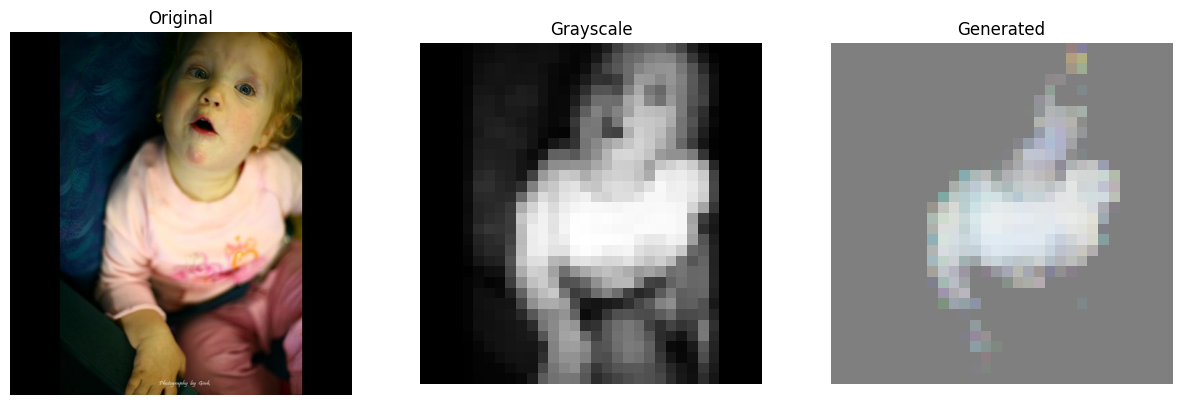

torch.Size([1, 1, 32, 32])


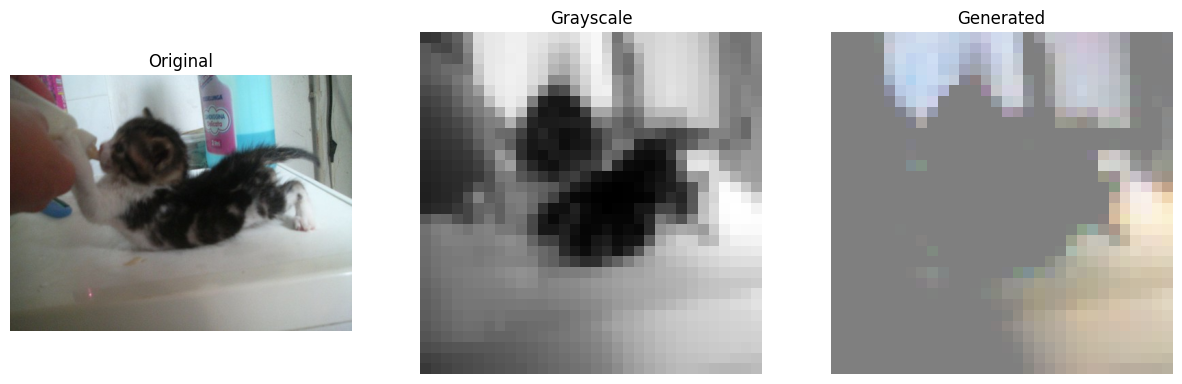

torch.Size([1, 1, 32, 32])


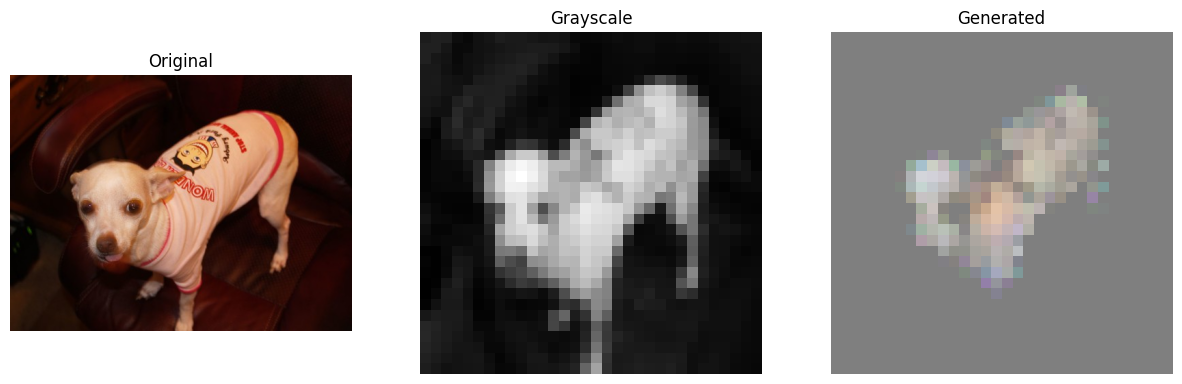

torch.Size([1, 1, 32, 32])


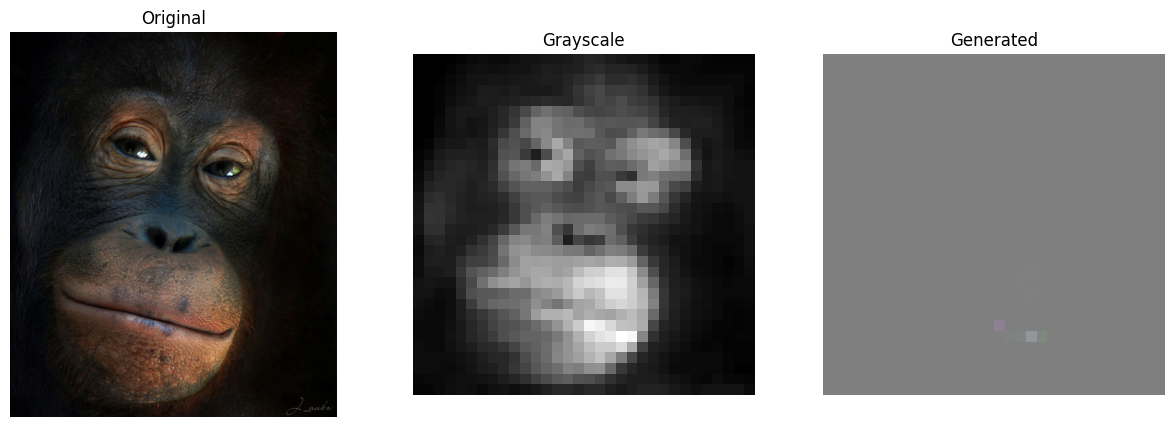

torch.Size([1, 1, 32, 32])


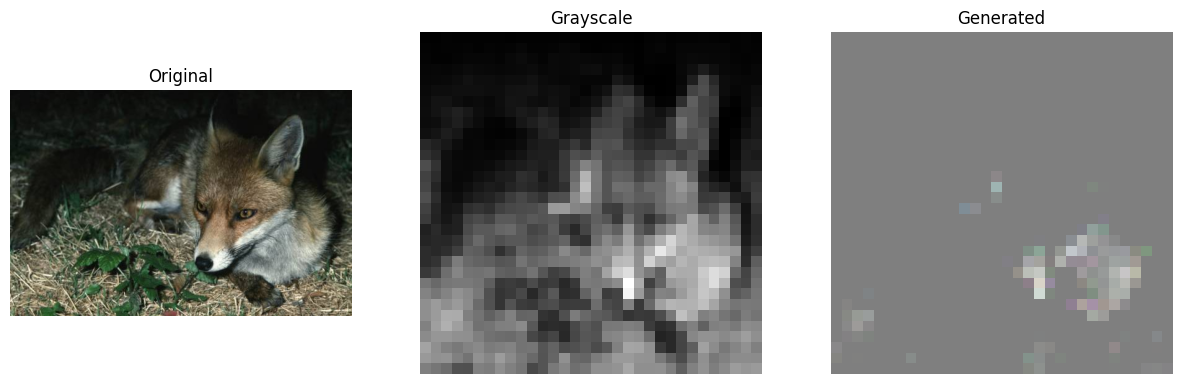

In [31]:
# TO BE COMPLETED
# Import the necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
import requests
from PIL import Image
from io import BytesIO

# Load the generator model
G = torch.load("generator3.pth") # Load the generator model from a file
G.eval() # Set the generator model to evaluation mode

# Define the image transformations
transform = transforms.Compose([
    transforms.Grayscale(), # Convert the images to grayscale
    transforms.Resize((32, 32)), # Resize the images to 32x32 pixels
    transforms.ToTensor(), # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5,)) # Normalize the images
])

# Define the inverse transformation
inverse_transform = transforms.Compose([
    transforms.Normalize((-1,), (2,)), # Undo the normalization
    transforms.ToPILImage() # Convert the tensors to PIL images
])

# Define a function to display the images
def display_images(images, titles):
    # Display a list of images with titles
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, (image, title) in enumerate(zip(images, titles)):
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(title)
        axes[i].axis("off")
    plt.show()

# Define a list of sample ImageNet URLs from
# https://planspace.org/20170430-sampling_imagenet/
imagenet_urls = [
    "https://farm4.static.flickr.com/3175/2737866473_7958dc8760.jpg", #baby
    #"https://github.com/ajschumacher/imagen/blob/master/imagen/n00007846_152343_person.jpg", #man
    "https://farm4.static.flickr.com/3276/2875184020_9944005d0d.jpg", # gato
    "http://farm3.static.flickr.com/2199/1659368303_4dbf9b312a.jpg", # perro
    "https://farm3.static.flickr.com/2531/4094333885_e8462a8338.jpg", # mono
    "https://planspace.org/20170430-sampling_imagenet/img/n02118333_27_fox.jpg", #zorro
]

# Loop through the ImageNet URLs
for url in imagenet_urls:
    # Download the image
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    # Convert the image to grayscale and resize it
    gray_image = transform(image).cuda()
    # Generate a color image from the grayscale image
    gray_image_input = gray_image.unsqueeze(0)
    print(gray_image_input.shape)
    color_image = G(gray_image_input).squeeze(0)
    # Apply the inverse transformation to the images
    gray_image = inverse_transform(gray_image)
    color_image = inverse_transform(color_image)
    # Display the images
    display_images([image, gray_image, color_image], ["Original", "Grayscale", "Generated"])


### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [32]:
%%shell
jupyter nbconvert --to html /content/A3.ipynb

[NbConvertApp] Converting notebook /content/A3.ipynb to html
[NbConvertApp] Writing 59247863 bytes to /content/A3.html


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus

# Assignment Grading Rubric
The grading of the assignment will be based on the following categories:

(1) **10 Pt - EXPLORATORY QUESTIONS** These are basic questions that in most cases can be answered without requiring a fully working and trained neural network model. For example, data loading, processing and visualization, summary statistics, data exploration, model and training setup, etc.

(2) **10 Pt - MODEL** Student has successfully implemented all the required neural network models and has demonstrated successful training of the model without any errors.

(3) **10 Pt - RESULT** Students are evaluated based on the results achieved in comparison to the expected results of the assignment.

(4) **10 Pt - DISCUSSION QUESTIONS** Student demonstrated understanding beyond the basic exploratory questions, can answer some of the more challenging questions, and provide arguments for their model selection decisions.

(5) **10 Pt - COMMUNICATION** Student has provided a quality submission that is easy to read without too many unnecessary output statements that distract the reading of the document. The code has been well commented and all the answers are communicated clearly and concisely.

(6) **10 Pt - BONUS** Student has completed the assignment and has taken on the challenging bonus tasks listed in PART C. The student has demonstrated a good understanding of all aspects of the assignment and has exceeded expectations for the assignment.



**TOTAL GRADE = _____ of 50 Pts**